In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
def seed_everything(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

seed_everything(42)

In [ ]:
def load(filename):
    emdeb = np.load(filename)
    return list(emdeb)

In [ ]:
columns = ['clipTarget', 'date']
df = pd.DataFrame(columns=['clipTarget', "audio"])
for i in range(7):
    csv_filepath = f"/content/drive/MyDrive/ASR/0000{i}.csv"
    audio_filepath = f"/content/drive/MyDrive/ASR/AudioEmbedding/0000{i}.npy"
    temp = pd.read_csv(csv_filepath)
    temp = temp[columns]
    temp["audio"] = load(audio_filepath)
    df = pd.concat([df, temp], ignore_index=True)
    df = df.reset_index(drop=True)
df = df.sort_values(by=['date'], ascending=True)
df = df.reset_index(drop=True)

df_train = df.iloc[:324160, :]
df_train = df_train.reset_index(drop=True)


df_test = df.iloc[324160:, :]
df_test = df_test.reset_index(drop=True)
del df

In [ ]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df_train["clipTarget"].to_list()), y=df_train["clipTarget"].to_list())

In [ ]:
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, weights=torch.from_numpy(class_weights).cuda(), gamma=1.1):
        super().__init__()
        self.weights = weights
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = inputs.squeeze()
        targets = targets.squeeze()

        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.weights[targets]*(1-pt)**self.gamma * BCE_loss

        return F_loss.mean()

focal = WeightedFocalLoss()

In [ ]:

class CLIPDataset(Dataset):
    def __init__(self, audio, target, classes: str = "/content/drive/MyDrive/ASR/classes.json"):
        self.audio = audio
        self.target = target
        self.cat = self.read(classes)

    def __getitem__(self, item):
        return {
            "audio": torch.from_numpy(self.audio[item]),
            "target": self.cat[self.target[item]]
        }

    def __len__(self):
        return len(self.target)

    @staticmethod
    def read(filename: str):
        with open(filename, "r") as f:
            data = json.load(f)
        return data

In [ ]:
BATCH_SIZE = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = CLIPDataset(df_train["audio"].to_list(), df_train["clipTarget"].to_list())
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

test_dataset = CLIPDataset(df_test["audio"].to_list(), df_test["clipTarget"].to_list())
test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [ ]:
class Flatten2(nn.Module):
    """
    Takes a vector of shape (A, B, C, D, E, ...)
    and flattens everything but the first two dimensions, 
    giving a result of shape (A, B, C*D*E*...)
    """
    def forward(self, input):
        return input.view(input.size(0), 1, -1)


class Combiner(nn.Module):
    """
    This class is used to combine a feature exraction network F and a importance prediction network W,
    and combine their outputs by adding and summing them together. 
    """

    def __init__(self, featureExtraction, weightSelection):
        """
        featureExtraction: a network that takes an input of shape (B, T, D) and outputs a new 
            representation of shape (B, T, D'). 
        weightSelection: a network that takes in an input of shape (B, T, D') and outputs a 
            tensor of shape (B, T, 1) or (B, T). It should be normalized, so that the T 
            values at the end sum to one (torch.sum(_, dim=1) = 1.0)
        """
        super(Combiner, self).__init__()
        self.featureExtraction = featureExtraction
        self.weightSelection = weightSelection
    
    def forward(self, input):
        """
        input: a tensor of shape (B, T, D)
        return: a new tensor of shape (B, D')
        """
        features = self.featureExtraction(input) #(B, T, D) $\boldsymbol{h}_i = F(\boldsymbol{x}_i)$
        weights = self.weightSelection(features) #(B, T) or (B, T, 1) for $\boldsymbol{\alpha}$
        if len(weights.shape) == 2: #(B, T) shape
            weights.unsqueese(2) #now (B, T, 1) shape
        
        r = features*weights #(B, T, D), computes $\alpha_i \cdot \boldsymbol{h}_i$
        
        return torch.sum(r, dim=1) #sum over the T dimension, giving (B, D) final shape $\bar{\boldsymbol{x}}$

T = 1
D = 1024
neurons = 128
classes = 52

backboneNetwork = nn.Sequential(
    Flatten2(),# Shape is now (B, T, D)
    nn.Linear(D, neurons), #Shape becomes (B, T, neurons)
    nn.LeakyReLU(),
    nn.Linear(neurons, neurons),
    nn.LeakyReLU(), #still (B, T, neurons) on the way out
)

attentionMechanism = nn.Sequential(
    #Shape is (B, T, neurons)
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1), # (B, T, 1)
    nn.Softmax(dim=1),
)

model = nn.Sequential(
    #input is (B, T, C, W, H). backbone & attention will be used by combiner to process
    Combiner(backboneNetwork, attentionMechanism), # result is (B, neurons)
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes)
)

In [ ]:
class Model1D(nn.Module):
    def __init__(
        self,
        input: int,
        hidden: int,
        classes: int
    ):
        super(Model1D, self).__init__()
        self.norm0 = nn.BatchNorm1d(input)
        self.conv1 = nn.Conv1d(in_channels=input, out_channels=hidden, kernel_size=5)
        self.norm1 = nn.BatchNorm1d(hidden)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=hidden, out_channels=2 * hidden, kernel_size=5)
        self.norm2 = nn.BatchNorm1d(2 * hidden)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.conv3 = nn.Conv1d(in_channels=2 * hidden, out_channels=3 * hidden, kernel_size=5)
        self.norm3 = nn.BatchNorm1d(3 * hidden)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.conv4 = nn.Conv1d(in_channels=3 * hidden, out_channels=3 * hidden, kernel_size=5)
        self.norm4 = nn.BatchNorm1d(3 * hidden)
        self.relu4 = nn.ReLU()
        self.avgpool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(in_features=3 * hidden, out_features=classes)


    def forward(self, x):
        x = self.norm0(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.norm4(x)
        x = self.relu4(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        return self.fc(x)

In [ ]:
# import torch
# import torch.nn as nn

# f1-score 0.115
# class MLP(nn.Module):
#     def __init__(
#             self,
#             in_features: int = 128,
#             hidden_features: int = 256,
#             out_features: int = 52,
#             num_layers: int = 1,
#             dropout_prob: float = 0.2,
#             bn: bool = True
#     ):
#         super(MLP, self).__init__()
#         #self.bn = bn
#         self.bn1 = nn.BatchNorm1d(in_features)
#         self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
#         self.act1 = nn.ReLU()
#         self.bn2 = nn.BatchNorm1d(hidden_features)
#         self.dropout1 = nn.Dropout(dropout_prob)
#         self.fc2 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
#         self.dropout2 = nn.Dropout(dropout_prob)
#         self.fc3 = nn.Linear(in_features=hidden_features, out_features=out_features)


#     def forward(self, x):
#         # x = self.dropout1(x)
#         # x = self.bn1(x)
#         x = self.fc1(x)
#         x = self.bn2(x)
#         x = self.act1(x)
#         x = self.dropout2(x)
#         return self.fc3(x)


class MLP(nn.Module): # f1-score 0.124
    def __init__(
            self,
            in_features: int = 128,
            hidden_features: int = 256,
            out_features: int = 52,
            num_layers: int = 1,
            dropout_prob: float = 0.1,
            bn: bool = True
    ):
        super(MLP, self).__init__()
        #self.bn = bn
        self.bn1 = nn.BatchNorm1d(in_features)
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.act1 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_features)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(in_features=hidden_features, out_features=out_features)


    def forward(self, x):
        # x = self.dropout1(x)
        # x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.act1(x)
        #x = self.dropout2(x)
        return self.fc3(x)


# model = MLP()

Epoch: 1/20


val: 100%|██████████| 100/100 [00:00<00:00, 221.52it/s]


Epoch: 2/20


val: 100%|██████████| 100/100 [00:00<00:00, 328.16it/s]


Epoch: 3/20


val: 100%|██████████| 100/100 [00:00<00:00, 327.32it/s]


Epoch: 4/20


val: 100%|██████████| 100/100 [00:00<00:00, 323.75it/s]


Epoch: 5/20


val: 100%|██████████| 100/100 [00:00<00:00, 341.34it/s]


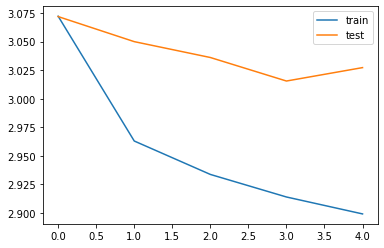

Epoch: 6/20


val: 100%|██████████| 100/100 [00:00<00:00, 328.97it/s]


Epoch: 7/20


val: 100%|██████████| 100/100 [00:00<00:00, 321.78it/s]


Epoch: 8/20


val: 100%|██████████| 100/100 [00:00<00:00, 315.18it/s]


Epoch: 9/20


val: 100%|██████████| 100/100 [00:00<00:00, 326.38it/s]


Epoch: 10/20


val: 100%|██████████| 100/100 [00:00<00:00, 314.67it/s]


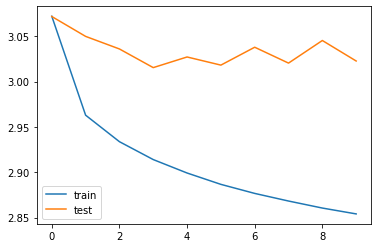

Epoch: 11/20


val: 100%|██████████| 100/100 [00:00<00:00, 332.32it/s]


Epoch: 12/20


val: 100%|██████████| 100/100 [00:00<00:00, 331.19it/s]


Epoch: 13/20


val: 100%|██████████| 100/100 [00:00<00:00, 309.05it/s]


Epoch: 14/20


val: 100%|██████████| 100/100 [00:00<00:00, 332.82it/s]


Epoch: 15/20


val: 100%|██████████| 100/100 [00:00<00:00, 301.13it/s]


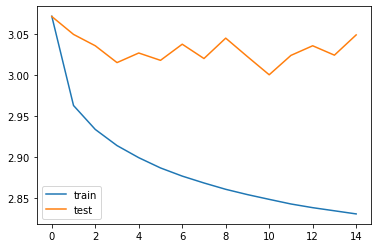

Epoch: 16/20


val: 100%|██████████| 100/100 [00:00<00:00, 338.05it/s]


Epoch: 17/20


val: 100%|██████████| 100/100 [00:00<00:00, 312.85it/s]


Epoch: 18/20


val: 100%|██████████| 100/100 [00:00<00:00, 319.36it/s]


Epoch: 19/20


val: 100%|██████████| 100/100 [00:00<00:00, 334.89it/s]


Epoch: 20/20


val: 100%|██████████| 100/100 [00:00<00:00, 319.09it/s]


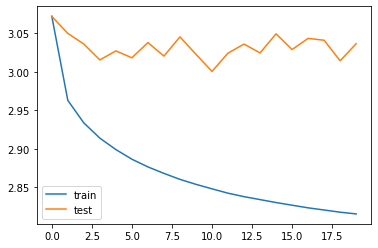

In [ ]:
PATH = "/content/drive/MyDrive/ASR/CNN"
EPOCHS = 20
LearningRate = 0.001
EXPERIMENT_NAME = "MLP_AUDIO"


model = MLP(hidden_features=256)
opt = optim.AdamW(model.parameters(), lr=LearningRate)

criterion = nn.CrossEntropyLoss()

mean_loss_train = []
mean_score_train = []

mean_loss_test = []
mean_score_test = []

best_loss = float("inf")
best_score = 0
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    model.train().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(train_dataloader, desc="train"):
        target = data["target"].to(device)
        audio = data["audio"].to(device)  # MLP
        # audio = data["audio"].to(device).unsqueeze(1) # CNN1D
        opt.zero_grad()

        preds = model(audio)
        loss = criterion(preds, target)
        loss.backward()

        running_loss += loss.item() * len(data["audio"])
        counter += len(data["audio"])

        opt.step()

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        running_score += f1_score(target, preds, average='macro')

    mean_loss_train.append(running_loss / counter)
    mean_score_train.append(running_score / len(train_dataloader))
    #print('Loss/train', running_loss / counter)
    #print('F1/train', running_score / counter)

    with torch.no_grad():
        model.eval().to(device)
        running_loss = 0
        running_score = 0
        counter = 0
        for data in tqdm(test_dataloader, desc="val"):
            target = data["target"].to(device)
            audio = data["audio"].to(device)  # MLP
            # audio = data["audio"].to(device).unsqueeze(1) # CNN1D

            preds = model(audio)
            loss = criterion(preds, target)

            running_loss += loss.item() * len(data["audio"])
            counter += len(data["audio"])

            preds = preds.argmax(axis=1).cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            running_score += f1_score(target, preds, average='macro')


    #print('F1/val', running_loss / counter)
    #print('Loss/val', running_score / counter)
    mean_loss_test.append(running_loss / counter)
    mean_score_test.append(running_score / len(test_dataloader))

    # if running_score > best_score and running_loss < best_loss:
    #     best_score = running_score
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_score > best_score:
    #     best_score = running_score
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_loss < best_loss:
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif epoch == EPOCHS - 1:
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))

    if (epoch + 1) % 5 == 0:
        plt.plot(np.arange(len(mean_loss_train)), mean_loss_train, label="train")
        plt.plot(np.arange(len(mean_loss_test)), mean_loss_test, label="test")
        plt.legend()
        plt.show()

Epoch: 1/20


val: 100%|██████████| 100/100 [00:00<00:00, 121.02it/s]


Epoch: 2/20


val: 100%|██████████| 100/100 [00:00<00:00, 311.96it/s]


Epoch: 3/20


val: 100%|██████████| 100/100 [00:00<00:00, 332.64it/s]


Epoch: 4/20


val: 100%|██████████| 100/100 [00:00<00:00, 336.51it/s]


Epoch: 5/20


val: 100%|██████████| 100/100 [00:00<00:00, 250.02it/s]


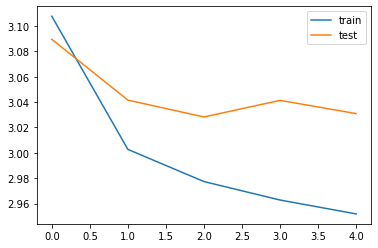

Epoch: 6/20


val: 100%|██████████| 100/100 [00:00<00:00, 328.20it/s]


Epoch: 7/20


val: 100%|██████████| 100/100 [00:00<00:00, 250.18it/s]


Epoch: 8/20


val: 100%|██████████| 100/100 [00:00<00:00, 246.39it/s]


Epoch: 9/20


val: 100%|██████████| 100/100 [00:00<00:00, 256.14it/s]


Epoch: 10/20


val: 100%|██████████| 100/100 [00:00<00:00, 320.35it/s]


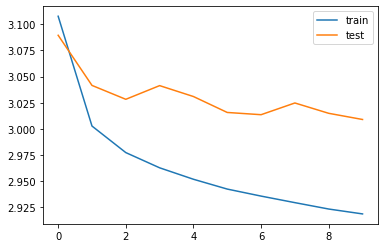

Epoch: 11/20


val: 100%|██████████| 100/100 [00:00<00:00, 326.30it/s]


Epoch: 12/20


val: 100%|██████████| 100/100 [00:00<00:00, 311.57it/s]


Epoch: 13/20


val: 100%|██████████| 100/100 [00:00<00:00, 329.14it/s]


Epoch: 14/20


val: 100%|██████████| 100/100 [00:00<00:00, 317.03it/s]


Epoch: 15/20


val: 100%|██████████| 100/100 [00:00<00:00, 322.18it/s]


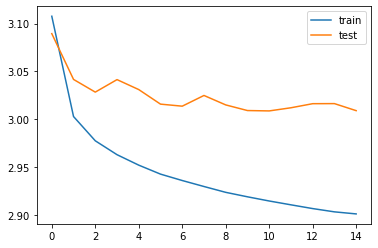

Epoch: 16/20


val: 100%|██████████| 100/100 [00:00<00:00, 315.78it/s]


Epoch: 17/20


val: 100%|██████████| 100/100 [00:00<00:00, 332.81it/s]


Epoch: 18/20


val: 100%|██████████| 100/100 [00:00<00:00, 304.10it/s]


Epoch: 19/20


val: 100%|██████████| 100/100 [00:00<00:00, 330.33it/s]


Epoch: 20/20


val: 100%|██████████| 100/100 [00:00<00:00, 306.45it/s]


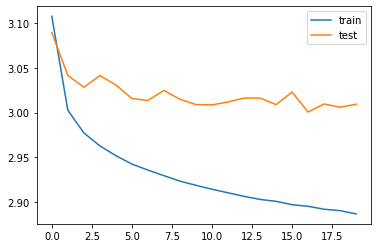

In [ ]:
PATH = "/content/drive/MyDrive/ASR/CNN"
EPOCHS = 20
LearningRate = 0.001
EXPERIMENT_NAME = "MLP_AUDIO"


model = MLP(hidden_features=256)
opt = optim.AdamW(model.parameters(), lr=LearningRate)

criterion = nn.CrossEntropyLoss()

mean_loss_train = []
mean_score_train = []

mean_loss_test = []
mean_score_test = []

best_loss = float("inf")
best_score = 0
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    model.train().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(train_dataloader, desc="train"):
        target = data["target"].to(device)
        audio = data["audio"].to(device)  # MLP
        # audio = data["audio"].to(device).unsqueeze(1) # CNN1D
        opt.zero_grad()

        preds = model(audio)
        loss = criterion(preds, target)
        loss.backward()

        running_loss += loss.item() * len(data["audio"])
        counter += len(data["audio"])

        opt.step()

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        running_score += f1_score(target, preds, average='macro')

    mean_loss_train.append(running_loss / counter)
    mean_score_train.append(running_score / len(train_dataloader))
    #print('Loss/train', running_loss / counter)
    #print('F1/train', running_score / counter)

    with torch.no_grad():
        model.eval().to(device)
        running_loss = 0
        running_score = 0
        counter = 0
        for data in tqdm(test_dataloader, desc="val"):
            target = data["target"].to(device)
            audio = data["audio"].to(device)  # MLP
            # audio = data["audio"].to(device).unsqueeze(1) # CNN1D

            preds = model(audio)
            loss = criterion(preds, target)

            running_loss += loss.item() * len(data["audio"])
            counter += len(data["audio"])

            preds = preds.argmax(axis=1).cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            running_score += f1_score(target, preds, average='macro')


    #print('F1/val', running_loss / counter)
    #print('Loss/val', running_score / counter)
    mean_loss_test.append(running_loss / counter)
    mean_score_test.append(running_score / len(test_dataloader))

    # if running_score > best_score and running_loss < best_loss:
    #     best_score = running_score
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_score > best_score:
    #     best_score = running_score
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_loss < best_loss:
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif epoch == EPOCHS - 1:
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))

    if (epoch + 1) % 5 == 0:
        plt.plot(np.arange(len(mean_loss_train)), mean_loss_train, label="train")
        plt.plot(np.arange(len(mean_loss_test)), mean_loss_test, label="test")
        plt.legend()
        plt.show()

In [ ]:
# torch.save(model.cpu().state_dict(), os.path.join("/content/drive/MyDrive/ASR/Manual/audio_f10124.pt"))

In [ ]:
model = MLP(hidden_features=256)
model.load_state_dict(torch.load("/content/drive/MyDrive/ASR/Manual/audio_f10124.pt"))

<All keys matched successfully>

In [ ]:
predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        audio = data["audio"].to(device)  # MLP
        # audio = data["audio"].to(device).unsqueeze(1) # CNN1D

        preds = model(audio)

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        predictions.extend(list(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 286.72it/s]


In [ ]:
f1_score(gt, predictions, average='macro')

0.12423691389155031

In [ ]:
softmax = nn.Softmax(dim=1) 

predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        audio = data["audio"].to(device)  # MLP
        # audio = data["audio"].to(device).unsqueeze(1) # CNN1D

        preds = model(audio)

        preds = softmax(preds.cpu()).detach().numpy()
        predictions.extend(np.array(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 277.07it/s]


In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovr")

0.7735017869236935

In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovo")

0.7713241159744334

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovr")

0.7735017869236935

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovo")

0.7713241159744334

In [ ]:
class Model1D(nn.Module):
    def __init__(
        self,
        input: int,
        hidden: int,
        classes: int
    ):
        super(Model1D, self).__init__()
        self.norm0 = nn.BatchNorm1d(input)
        self.conv1 = nn.Conv1d(in_channels=input, out_channels=hidden, kernel_size=5)
        self.norm1 = nn.BatchNorm1d(hidden)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=hidden, out_channels=2 * hidden, kernel_size=5)
        self.norm2 = nn.BatchNorm1d(2 * hidden)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.conv3 = nn.Conv1d(in_channels=2 * hidden, out_channels=3 * hidden, kernel_size=5)
        self.norm3 = nn.BatchNorm1d(3 * hidden)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.conv4 = nn.Conv1d(in_channels=3 * hidden, out_channels=3 * hidden, kernel_size=5)
        self.norm4 = nn.BatchNorm1d(3 * hidden)
        self.relu4 = nn.ReLU()
        self.avgpool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(in_features=240, out_features=classes)


    def forward(self, x):
        x = self.norm0(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = x.flatten(1)
        return self.fc(x)
model = Model1D(1, 1, 52).to(device)



In [ ]:
PATH = "/content/drive/MyDrive/ASR/CNN"
EPOCHS = 5
LearningRate = 0.001
EXPERIMENT_NAME = "CNN1D_AUDIO"


#model = Model1D(1, 128, 52).to(device)
opt = optim.Adam(model.parameters(), lr=LearningRate)

criterion = nn.CrossEntropyLoss()

mean_loss_train = []
mean_score_train = []

mean_loss_test = []
mean_score_test = []

best_loss = float("inf")
best_score = 0
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    model.train().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(train_dataloader, desc="train"):
        target = data["target"].to(device)
        # audio = data["audio"].to(device)  # MLP
        audio = data["audio"].to(device).unsqueeze(1) # CNN1D
        opt.zero_grad()

        preds = model(audio)
        loss = criterion(preds, target)
        loss.backward()

        running_loss += loss.item() * len(data["audio"])
        counter += len(data["audio"])

        opt.step()

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        running_score += f1_score(target, preds, average='macro')

    mean_loss_train.append(running_loss / counter)
    mean_score_train.append(running_score / len(train_dataloader))
    #print('Loss/train', running_loss / counter)
    #print('F1/train', running_score / counter)

    with torch.no_grad():
        model.eval().to(device)
        running_loss = 0
        running_score = 0
        counter = 0
        for data in tqdm(test_dataloader, desc="val"):
            target = data["target"].to(device)
            #audio = data["audio"].to(device)  # MLP
            audio = data["audio"].to(device).unsqueeze(1) # CNN1D

            preds = model(audio)
            loss = criterion(preds, target)

            running_loss += loss.item() * len(data["audio"])
            counter += len(data["audio"])

            preds = preds.argmax(axis=1).cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            running_score += f1_score(target, preds, average='macro')


    #print('F1/val', running_loss / counter)
    #print('Loss/val', running_score / counter)
    mean_loss_test.append(running_loss / counter)
    mean_score_test.append(running_score / len(test_dataloader))

    if running_score > best_score and running_loss < best_loss:
        best_score = running_score
        best_loss = running_loss
        torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    elif running_score > best_score:
        best_score = running_score
        torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    elif running_loss < best_loss:
        best_loss = running_loss
        torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    elif epoch == EPOCHS - 1:
        torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))

    if (epoch + 1) % 5 == 0:
        plt.plot(np.arange(len(mean_loss_train)), mean_loss_train, label="train")
        plt.plot(np.arange(len(mean_loss_test)), mean_loss_test, label="test")
        plt.legend()
        plt.show()

In [ ]:
predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        # audio = data["audio"].to(device)  # MLP
        audio = data["audio"].to(device).unsqueeze(1) # CNN1D

        preds = model(audio)

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        predictions.extend(list(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 285.48it/s]


In [ ]:
f1_score(gt, predictions, average='macro')

0.10121471097259066

In [ ]:
softmax = nn.Softmax(dim=1) 

predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        # audio = data["audio"].to(device)  # MLP
        audio = data["audio"].to(device).unsqueeze(1) # CNN1D

        preds = model(audio)

        preds = softmax(preds.cpu()).detach().numpy()
        predictions.extend(np.array(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 363.46it/s]


In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovr")

0.7614637577897934

In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovo")

0.7594232328927221

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovr")

0.7614637577897934

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovo")

0.7594232328927221

In [ ]:
columns = ['clipTarget', 'date']
df = pd.DataFrame(columns=['clipTarget', "video"])
for i in range(7):
    csv_filepath = f"/content/drive/MyDrive/ASR/0000{i}.csv"
    audio_filepath = f"/content/drive/MyDrive/ASR/ContentEmbedding/0000{i}.npy"
    temp = pd.read_csv(csv_filepath)
    temp = temp[columns]
    temp["video"] = load(audio_filepath)
    df = pd.concat([df, temp], ignore_index=True)
    df = df.reset_index(drop=True)
df = df.sort_values(by=['date'], ascending=True)
df = df.reset_index(drop=True)

df_train = df.iloc[:324160, :]
df_train = df_train.reset_index(drop=True)


df_test = df.iloc[324160:, :]
df_test = df_test.reset_index(drop=True)
del df


class CLIPDataset(Dataset):
    def __init__(self, video, target, classes: str = "/content/drive/MyDrive/ASR/classes.json"):
        self.video = video
        self.target = target
        self.cat = self.read(classes)

    def __getitem__(self, item):
        return {
            "video": torch.from_numpy(self.video[item]),
            "target": self.cat[self.target[item]]
        }

    def __len__(self):
        return len(self.target)

    @staticmethod
    def read(filename: str):
        with open(filename, "r") as f:
            data = json.load(f)
        return data


BATCH_SIZE = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = CLIPDataset(df_train["video"].to_list(), df_train["clipTarget"].to_list())
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

test_dataset = CLIPDataset(df_test["video"].to_list(), df_test["clipTarget"].to_list())
test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [ ]:
class MLP(nn.Module): # f1-score 0.124
    def __init__(
            self,
            in_features: int = 128,
            hidden_features: int = 256,
            out_features: int = 52,
            num_layers: int = 1,
            dropout_prob: float = 0.1,
            bn: bool = True
    ):
        super(MLP, self).__init__()
        #self.bn = bn
        self.bn1 = nn.BatchNorm1d(in_features)
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.act1 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_features)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(in_features=hidden_features, out_features=out_features)


    def forward(self, x):
        # x = self.dropout1(x)
        # x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.act1(x)
        #x = self.dropout2(x)
        return self.fc3(x)

class Flatten2(nn.Module):
    """
    Takes a vector of shape (A, B, C, D, E, ...)
    and flattens everything but the first two dimensions, 
    giving a result of shape (A, B, C*D*E*...)
    """
    def forward(self, input):
        return input.view(input.size(0), 1, -1)


class Combiner(nn.Module):
    """
    This class is used to combine a feature exraction network F and a importance prediction network W,
    and combine their outputs by adding and summing them together. 
    """

    def __init__(self, featureExtraction, weightSelection):
        """
        featureExtraction: a network that takes an input of shape (B, T, D) and outputs a new 
            representation of shape (B, T, D'). 
        weightSelection: a network that takes in an input of shape (B, T, D') and outputs a 
            tensor of shape (B, T, 1) or (B, T). It should be normalized, so that the T 
            values at the end sum to one (torch.sum(_, dim=1) = 1.0)
        """
        super(Combiner, self).__init__()
        self.featureExtraction = featureExtraction
        self.weightSelection = weightSelection
    
    def forward(self, input):
        """
        input: a tensor of shape (B, T, D)
        return: a new tensor of shape (B, D')
        """
        features = self.featureExtraction(input) #(B, T, D) $\boldsymbol{h}_i = F(\boldsymbol{x}_i)$
        weights = self.weightSelection(features) #(B, T) or (B, T, 1) for $\boldsymbol{\alpha}$
        if len(weights.shape) == 2: #(B, T) shape
            weights.unsqueese(2) #now (B, T, 1) shape
        
        r = features*weights #(B, T, D), computes $\alpha_i \cdot \boldsymbol{h}_i$
        
        return torch.sum(r, dim=1) #sum over the T dimension, giving (B, D) final shape $\bar{\boldsymbol{x}}$

T = 1
D = 1024
neurons = 128
classes = 52

backboneNetwork = nn.Sequential(
    Flatten2(),# Shape is now (B, T, D)
    nn.Linear(D, neurons), #Shape becomes (B, T, neurons)
    nn.LeakyReLU(),
    nn.Linear(neurons, neurons),
    nn.LeakyReLU(), #still (B, T, neurons) on the way out
)

attentionMechanism = nn.Sequential(
    #Shape is (B, T, neurons)
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1), # (B, T, 1)
    nn.Softmax(dim=1),
)

model = nn.Sequential(
    #input is (B, T, C, W, H). backbone & attention will be used by combiner to process
    Combiner(backboneNetwork, attentionMechanism), # result is (B, neurons)
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes)
)

Epoch: 1/5


val: 100%|██████████| 100/100 [00:00<00:00, 219.24it/s]


Epoch: 2/5


val: 100%|██████████| 100/100 [00:00<00:00, 177.28it/s]


Epoch: 3/5


val: 100%|██████████| 100/100 [00:00<00:00, 184.62it/s]


Epoch: 4/5


val: 100%|██████████| 100/100 [00:00<00:00, 184.71it/s]


Epoch: 5/5


val: 100%|██████████| 100/100 [00:00<00:00, 182.20it/s]


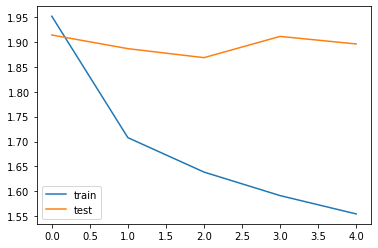

In [ ]:
PATH = "/content/drive/MyDrive/ASR/CNN"
EPOCHS = 5
LearningRate = 0.001
EXPERIMENT_NAME = "MLP_VIDEO"


#model = MLP(1024, 64)
opt = optim.Adam(model.parameters(), lr=LearningRate)

criterion = nn.CrossEntropyLoss()

mean_loss_train = []
mean_score_train = []

mean_loss_test = []
mean_score_test = []

best_loss = float("inf")
best_score = 0
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    model.train().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(train_dataloader, desc="train"):
        target = data["target"].to(device)
        audio = data["video"].to(device)  # MLP
        # audio = data["audio"].to(device).unsqueeze(1) # CNN1D
        opt.zero_grad()

        preds = model(audio)
        loss = criterion(preds, target)
        loss.backward()

        running_loss += loss.item() * len(data["video"])
        counter += len(data["video"])

        opt.step()

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        running_score += f1_score(target, preds, average='macro')

    mean_loss_train.append(running_loss / counter)
    mean_score_train.append(running_score / len(train_dataloader))
    #print('Loss/train', running_loss / counter)
    #print('F1/train', running_score / counter)

    with torch.no_grad():
        model.eval().to(device)
        running_loss = 0
        running_score = 0
        counter = 0
        for data in tqdm(test_dataloader, desc="val"):
            target = data["target"].to(device)
            audio = data["video"].to(device)  # MLP
            # audio = data["audio"].to(device).unsqueeze(1) # CNN1D

            preds = model(audio)
            loss = criterion(preds, target)

            running_loss += loss.item() * len(data["video"])
            counter += len(data["video"])

            preds = preds.argmax(axis=1).cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            running_score += f1_score(target, preds, average='macro')


    #print('F1/val', running_loss / counter)
    #print('Loss/val', running_score / counter)
    mean_loss_test.append(running_loss / counter)
    mean_score_test.append(running_score / len(test_dataloader))

    # if running_score > best_score and running_loss < best_loss:
    #     best_score = running_score
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_score > best_score:
    #     best_score = running_score
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_loss < best_loss:
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif epoch == EPOCHS - 1:
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))

    if (epoch + 1) % 5 == 0 or (epoch + 1) == EPOCHS:
        plt.plot(np.arange(len(mean_loss_train)), mean_loss_train, label="train")
        plt.plot(np.arange(len(mean_loss_test)), mean_loss_test, label="test")
        plt.legend()
        plt.show()

In [ ]:
torch.save(model.cpu().state_dict(), "/content/drive/MyDrive/ASR/Manual/attention_video_5e.pt")

In [ ]:
predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        audio = data["video"].to(device)  # MLP
        # audio = data["audio"].to(device).unsqueeze(1) # CNN1D

        preds = model(audio)

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        predictions.extend(list(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 289.17it/s]


In [ ]:
f1_score(gt, predictions, average='macro')

0.2966668435235124

In [ ]:
softmax = nn.Softmax(dim=1) 

predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        audio = data["video"].to(device)  # MLP
        #audio = data["audio"].to(device).unsqueeze(1) # CNN1D

        preds = model(audio)

        preds = softmax(preds.cpu()).detach().numpy()
        predictions.extend(np.array(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 273.34it/s]


In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovr")

0.906908409628486

In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovo")

0.8932220727676569

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovr")

0.906908409628486

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovo")

0.8932220727676569

In [ ]:
class Model1D(nn.Module):
    def __init__(
        self,
        input: int,
        hidden: int,
        classes: int
    ):
        super(Model1D, self).__init__()
        self.norm0 = nn.BatchNorm1d(input)
        self.conv1 = nn.Conv1d(in_channels=input, out_channels=hidden, kernel_size=5)
        self.norm1 = nn.BatchNorm1d(hidden)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=hidden, out_channels=2 * hidden, kernel_size=5)
        self.norm2 = nn.BatchNorm1d(2 * hidden)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=3)
        self.conv3 = nn.Conv1d(in_channels=2 * hidden, out_channels=3 * hidden, kernel_size=5)
        self.norm3 = nn.BatchNorm1d(3 * hidden)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=3)
        self.conv4 = nn.Conv1d(in_channels=3 * hidden, out_channels=3 * hidden, kernel_size=5)
        self.norm4 = nn.BatchNorm1d(3 * hidden)
        self.relu4 = nn.ReLU()
        self.avgpool = nn.MaxPool1d(kernel_size=4, stride=3)
        self.fc1 = nn.Linear(in_features=840, out_features=256)
        self.dropout = nn.Dropout(0.5)
        self.act1 = nn.ReLU()
        self.fc = nn.Linear(in_features=676, out_features=classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        return self.fc(x)

model = Model1D(1, 1, 52).to(device)
model(video).shape

torch.Size([512, 52])

Epoch: 1/20


val: 100%|██████████| 100/100 [00:00<00:00, 176.97it/s]


Epoch: 2/20


val: 100%|██████████| 100/100 [00:00<00:00, 180.21it/s]


Epoch: 3/20


val: 100%|██████████| 100/100 [00:00<00:00, 213.15it/s]


Epoch: 4/20


val: 100%|██████████| 100/100 [00:00<00:00, 213.59it/s]


Epoch: 5/20


val: 100%|██████████| 100/100 [00:00<00:00, 215.54it/s]


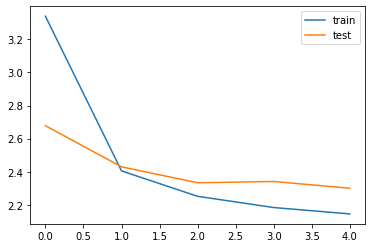

Epoch: 6/20


val: 100%|██████████| 100/100 [00:00<00:00, 218.22it/s]


Epoch: 7/20


val: 100%|██████████| 100/100 [00:00<00:00, 215.02it/s]


Epoch: 8/20


val: 100%|██████████| 100/100 [00:00<00:00, 205.53it/s]


Epoch: 9/20


val: 100%|██████████| 100/100 [00:00<00:00, 211.80it/s]


Epoch: 10/20


val: 100%|██████████| 100/100 [00:00<00:00, 212.07it/s]


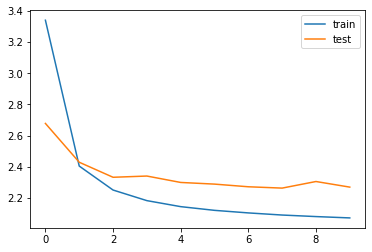

Epoch: 11/20


val: 100%|██████████| 100/100 [00:00<00:00, 218.00it/s]


Epoch: 12/20


val: 100%|██████████| 100/100 [00:00<00:00, 212.54it/s]


Epoch: 13/20


val: 100%|██████████| 100/100 [00:00<00:00, 208.94it/s]


Epoch: 14/20


val: 100%|██████████| 100/100 [00:00<00:00, 219.29it/s]


Epoch: 15/20


val: 100%|██████████| 100/100 [00:00<00:00, 211.72it/s]


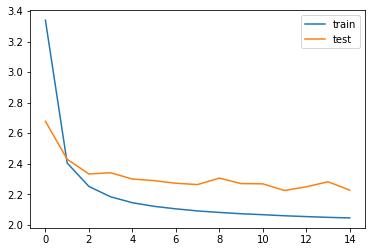

Epoch: 16/20


val: 100%|██████████| 100/100 [00:00<00:00, 211.57it/s]


Epoch: 17/20


val: 100%|██████████| 100/100 [00:00<00:00, 214.90it/s]


Epoch: 18/20


val: 100%|██████████| 100/100 [00:00<00:00, 207.32it/s]


Epoch: 19/20


val: 100%|██████████| 100/100 [00:00<00:00, 208.65it/s]


Epoch: 20/20


val: 100%|██████████| 100/100 [00:00<00:00, 206.54it/s]


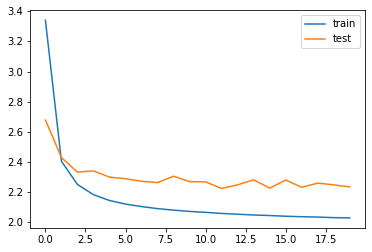

In [ ]:
PATH = "/content/drive/MyDrive/ASR/CNN"
EPOCHS = 20
LearningRate = 0.001
EXPERIMENT_NAME = "CNN1D_VIDEO"


# model = Model1D(1, 2, 52).to(device)
opt = optim.Adam(model.parameters(), lr=LearningRate)

criterion = nn.CrossEntropyLoss()

mean_loss_train = []
mean_score_train = []

mean_loss_test = []
mean_score_test = []

best_loss = float("inf")
best_score = 0
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    model.train().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(train_dataloader, desc="train"):
        target = data["target"].to(device)
        video = data["video"].to(device).unsqueeze(1) # CNN1D
        opt.zero_grad()

        preds = model(video)
        loss = criterion(preds, target)
        loss.backward()

        running_loss += loss.item() * len(data["video"])
        counter += len(data["video"])

        opt.step()

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        running_score += f1_score(target, preds, average='macro')

    mean_loss_train.append(running_loss / counter)
    mean_score_train.append(running_score / len(train_dataloader))
    #print('Loss/train', running_loss / counter)
    #print('F1/train', running_score / counter)

    with torch.no_grad():
        model.eval().to(device)
        running_loss = 0
        running_score = 0
        counter = 0
        for data in tqdm(test_dataloader, desc="val"):
            target = data["target"].to(device)
            video = data["video"].to(device).unsqueeze(1) # CNN1D

            preds = model(video)
            loss = criterion(preds, target)

            running_loss += loss.item() * len(data["video"])
            counter += len(data["video"])

            preds = preds.argmax(axis=1).cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            running_score += f1_score(target, preds, average='macro')


    #print('F1/val', running_loss / counter)
    #print('Loss/val', running_score / counter)
    mean_loss_test.append(running_loss / counter)
    mean_score_test.append(running_score / len(test_dataloader))

    # if running_score > best_score and running_loss < best_loss:
    #     best_score = running_score
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_score > best_score:
    #     best_score = running_score
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_loss < best_loss:
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif epoch == EPOCHS - 1:
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))

    if (epoch + 1) % 5 == 0:
        plt.plot(np.arange(len(mean_loss_train)), mean_loss_train, label="train")
        plt.plot(np.arange(len(mean_loss_test)), mean_loss_test, label="test")
        plt.legend()
        plt.show()

In [ ]:
# torch.save(model.cpu().state_dict(), "/content/drive/MyDrive/ASR/Manual/cnn1d_video_20e.pt")

In [ ]:
predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        video = data["video"].to(device).unsqueeze(1) # CNN1D

        preds = model(video)

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        predictions.extend(list(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 255.26it/s]


In [ ]:
f1_score(gt, predictions, average='macro')

0.2470818368100866

In [ ]:
softmax = nn.Softmax(dim=1) 

predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        video = data["video"].to(device).unsqueeze(1) # CNN1D

        preds = model(video)

        preds = softmax(preds.cpu()).detach().numpy()
        predictions.extend(np.array(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 225.87it/s]


In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovr")  

0.865906476412014

In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovo")

0.8517878743182135

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovr")

0.865906476412014

In [ ]:

roc_auc_score(gt, predictions, multi_class="ovo")

0.8517878743182135

In [ ]:
columns = ['clipTarget', 'date']
df = pd.DataFrame(columns=['clipTarget', "video", "audio"])
for i in range(7):
    csv_filepath = f"/content/drive/MyDrive/ASR/0000{i}.csv"
    video_filepath = f"/content/drive/MyDrive/ASR/ContentEmbedding/0000{i}.npy"
    audio_filepath = f"/content/drive/MyDrive/ASR/AudioEmbedding/0000{i}.npy"
    temp = pd.read_csv(csv_filepath)
    temp = temp[columns]
    temp["video"] = load(video_filepath)
    temp["audio"] = load(audio_filepath)
    df = pd.concat([df, temp], ignore_index=True)
    df = df.reset_index(drop=True)
df = df.sort_values(by=['date'], ascending=True)
df = df.reset_index(drop=True)

df_train = df.iloc[:324160, :]
df_train = df_train.reset_index(drop=True)


df_test = df.iloc[324160:, :]
df_test = df_test.reset_index(drop=True)
del df

In [ ]:
class CLIPDataset(Dataset):
    def __init__(self, audio, video, target, classes: str = "/content/drive/MyDrive/ASR/classes.json"):
        self.audio = audio
        self.video = video
        self.target = target
        self.cat = self.read(classes)

    def __getitem__(self, item):
        concat = np.concatenate((self.audio[item], self.video[item]))
        return {
            "video_audion": torch.from_numpy(concat),
            "target": self.cat[self.target[item]]
        }

    def __len__(self):
        return len(self.target)

    @staticmethod
    def read(filename: str):
        with open(filename, "r") as f:
            data = json.load(f)
        return data


BATCH_SIZE = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = CLIPDataset(df_train["audio"].to_list(), df_train["video"].to_list(), df_train["clipTarget"].to_list())
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

test_dataset = CLIPDataset(df_train["audio"].to_list(), df_test["video"].to_list(), df_test["clipTarget"].to_list())
test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [ ]:
T = 1
D = 1024 + 128
neurons = 64
classes = 52

backboneNetwork = nn.Sequential(
    Flatten2(),# Shape is now (B, T, D)
    nn.Linear(D, neurons), #Shape becomes (B, T, neurons)
    nn.LeakyReLU(),
    nn.Linear(neurons, neurons),
    nn.LeakyReLU(), #still (B, T, neurons) on the way out
)

attentionMechanism = nn.Sequential(
    #Shape is (B, T, neurons)
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1), # (B, T, 1)
    nn.Softmax(dim=1),
)

model = nn.Sequential(
    #input is (B, T, C, W, H). backbone & attention will be used by combiner to process
    Combiner(backboneNetwork, attentionMechanism), # result is (B, neurons)
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes)
)

In [ ]:
import torch
import torch.nn as nn


class MLP(nn.Module):
    def __init__(
            self,
            in_features: int = 128,
            hidden_features: int = 64,
            out_features: int = 52,
            num_layers: int = 1,
            dropout_prob: float = 0.5,
            bn: bool = True
    ):
        super(MLP, self).__init__()
        self.bn = bn
        self.dropout_prob = dropout_prob
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=out_features)




    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.act1(x)
        return self.fc2(x)

Epoch: 1/5


val: 100%|██████████| 100/100 [00:00<00:00, 122.11it/s]


Epoch: 2/5


val: 100%|██████████| 100/100 [00:00<00:00, 163.09it/s]


Epoch: 3/5


val: 100%|██████████| 100/100 [00:00<00:00, 167.55it/s]


Epoch: 4/5


val: 100%|██████████| 100/100 [00:00<00:00, 163.43it/s]


Epoch: 5/5


val: 100%|██████████| 100/100 [00:00<00:00, 165.22it/s]


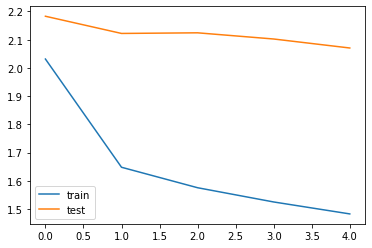

In [ ]:
PATH = "/content/drive/MyDrive/ASR/CONCAT"
EPOCHS = 5
LearningRate = 0.001
EXPERIMENT_NAME = "MLP_VIDEO_AUDIO_CONCAT_2"


# model = MLP(1024 + 128, 256, num_layers=4)
# model = MLP(1024 + 128, 512, num_layers=4)
model = MLP(1024 + 128, 512, num_layers=4, bn=False, dropout_prob=0)
opt = optim.Adam(model.parameters(), lr=LearningRate)

criterion = nn.CrossEntropyLoss()

mean_loss_train = []
mean_score_train = []

mean_loss_test = []
mean_score_test = []

best_loss = float("inf")
best_score = 0
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    model.train().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(train_dataloader, desc="train"):
        target = data["target"].to(device)
        video_audion = data["video_audion"].to(device)  # MLP
        # audio = data["audio"].to(device).unsqueeze(1) # CNN1D
        opt.zero_grad()

        preds = model(video_audion)
        loss = criterion(preds, target)
        loss.backward()

        running_loss += loss.item() * len(data["video_audion"])
        counter += len(data["video_audion"])

        opt.step()

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        running_score += f1_score(target, preds, average='macro')

    mean_loss_train.append(running_loss / counter)
    mean_score_train.append(running_score / len(train_dataloader))
    #print('Loss/train', running_loss / counter)
    #print('F1/train', running_score / counter)

    with torch.no_grad():
        model.eval().to(device)
        running_loss = 0
        running_score = 0
        counter = 0
        for data in tqdm(test_dataloader, desc="val"):
            target = data["target"].to(device)
            video_audion = data["video_audion"].to(device)  # MLP
            # audio = data["audio"].to(device).unsqueeze(1) # CNN1D

            preds = model(video_audion)
            loss = criterion(preds, target)

            running_loss += loss.item() * len(data["video_audion"])
            counter += len(data["video_audion"])

            preds = preds.argmax(axis=1).cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            running_score += f1_score(target, preds, average='macro')


    #print('F1/val', running_loss / counter)
    #print('Loss/val', running_score / counter)
    mean_loss_test.append(running_loss / counter)
    mean_score_test.append(running_score / len(test_dataloader))

    # if running_score > best_score and running_loss < best_loss:
    #     best_score = running_score
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_score > best_score:
    #     best_score = running_score
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_loss < best_loss:
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif epoch == EPOCHS - 1:
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))

    if (epoch + 1) % 5 == 0:
        plt.plot(np.arange(len(mean_loss_train)), mean_loss_train, label="train")
        plt.plot(np.arange(len(mean_loss_test)), mean_loss_test, label="test")
        plt.legend()
        plt.show()

In [ ]:
#torch.save(model.cpu().state_dict(), "/content/drive/MyDrive/ASR/Manual/mlp_audio_video_5e.pt")

In [ ]:
predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        video_audion = data["video_audion"].to(device)

        preds = model(video_audion)

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        predictions.extend(list(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 194.86it/s]


In [ ]:
f1_score(gt, predictions, average='macro')

0.2621985596277016

In [ ]:
softmax = nn.Softmax(dim=1) 

predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        video_audion = data["video_audion"].to(device)

        preds = model(video_audion)

        preds = softmax(preds.cpu()).detach().numpy()
        predictions.extend(np.array(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 184.31it/s]


In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovr")

0.8888636847354565

In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovo")

0.8730564337372373

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovr")

0.8888636847354565

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovo")

0.8730564337372373

In [ ]:
class Model1D(nn.Module):
    def __init__(
        self,
        input: int,
        hidden: int,
        classes: int
    ):
        super(Model1D, self).__init__()
        self.norm0 = nn.BatchNorm1d(input)
        self.conv1 = nn.Conv1d(in_channels=input, out_channels=hidden, kernel_size=5)
        self.norm1 = nn.BatchNorm1d(hidden)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=hidden, out_channels=2 * hidden, kernel_size=5)
        self.norm2 = nn.BatchNorm1d(2 * hidden)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=3)
        self.conv3 = nn.Conv1d(in_channels=2 * hidden, out_channels=3 * hidden, kernel_size=5)
        self.norm3 = nn.BatchNorm1d(3 * hidden)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=3)
        self.conv4 = nn.Conv1d(in_channels=3 * hidden, out_channels=3 * hidden, kernel_size=5)
        self.norm4 = nn.BatchNorm1d(3 * hidden)
        self.relu4 = nn.ReLU()
        self.avgpool = nn.MaxPool1d(kernel_size=4, stride=3)
        self.fc1 = nn.Linear(in_features=480, out_features=512)
        self.dropout = nn.Dropout(0.5)
        self.act1 = nn.ReLU()
        self.fc = nn.Linear(in_features=512, out_features=classes)


    def forward(self, x):
        #x = self.norm0(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        #x = self.norm3(x)
        x = self.relu3(x)
        x = self.pool2(x)
        x = self.conv4(x)
        #x = self.norm4(x)
        x = self.relu4(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.fc1(x)
        #x = self.dropout(x)
        x = self.act1(x)
        return self.fc(x)

model = Model1D(1, 4, 52).to(device)
model(video_audion).shape

torch.Size([305, 52])

Epoch: 1/10


val: 100%|██████████| 100/100 [00:00<00:00, 131.04it/s]


Epoch: 2/10


val: 100%|██████████| 100/100 [00:00<00:00, 129.78it/s]


Epoch: 3/10


val: 100%|██████████| 100/100 [00:00<00:00, 130.56it/s]


Epoch: 4/10


val: 100%|██████████| 100/100 [00:00<00:00, 131.70it/s]


Epoch: 5/10


val: 100%|██████████| 100/100 [00:00<00:00, 130.96it/s]


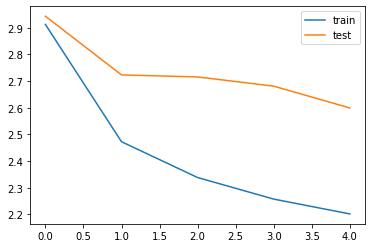

Epoch: 6/10


val: 100%|██████████| 100/100 [00:00<00:00, 126.81it/s]


Epoch: 7/10


val: 100%|██████████| 100/100 [00:00<00:00, 130.65it/s]


Epoch: 8/10


val: 100%|██████████| 100/100 [00:00<00:00, 129.00it/s]


Epoch: 9/10


val: 100%|██████████| 100/100 [00:00<00:00, 131.00it/s]


Epoch: 10/10


val: 100%|██████████| 100/100 [00:00<00:00, 111.59it/s]


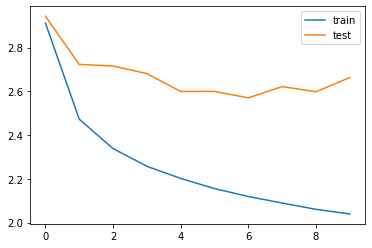

In [ ]:
PATH = "/content/drive/MyDrive/ASR/CONCAT"
EPOCHS = 10
LearningRate = 0.001
EXPERIMENT_NAME = "MLP_VIDEO_AUDIO_CONCAT_2_CNN"


opt = optim.Adam(model.parameters(), lr=LearningRate)

criterion = nn.CrossEntropyLoss()

mean_loss_train = []
mean_score_train = []

mean_loss_test = []
mean_score_test = []

best_loss = float("inf")
best_score = 0
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    model.train().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(train_dataloader, desc="train"):
        target = data["target"].to(device)
        video_audio = data["video_audion"].to(device).unsqueeze(1) # CNN1D
        opt.zero_grad()

        preds = model(video_audio)
        loss = criterion(preds, target)
        loss.backward()

        running_loss += loss.item() * len(data["video_audion"])
        counter += len(data["video_audion"])

        opt.step()

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        running_score += f1_score(target, preds, average='macro')

    mean_loss_train.append(running_loss / counter)
    mean_score_train.append(running_score / len(train_dataloader))
    #print('Loss/train', running_loss / counter)
    #print('F1/train', running_score / counter)

    with torch.no_grad():
        model.eval().to(device)
        running_loss = 0
        running_score = 0
        counter = 0
        for data in tqdm(test_dataloader, desc="val"):
            target = data["target"].to(device)
            video_audio = data["video_audion"].to(device).unsqueeze(1) # CNN1D

            preds = model(video_audio)
            loss = criterion(preds, target)

            running_loss += loss.item() * len(data["video_audion"])
            counter += len(data["video_audion"])

            preds = preds.argmax(axis=1).cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            running_score += f1_score(target, preds, average='macro')


    #print('F1/val', running_loss / counter)
    #print('Loss/val', running_score / counter)
    mean_loss_test.append(running_loss / counter)
    mean_score_test.append(running_score / len(test_dataloader))

    # if running_score > best_score and running_loss < best_loss:
    #     best_score = running_score
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_score > best_score:
    #     best_score = running_score
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif running_loss < best_loss:
    #     best_loss = running_loss
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))
    # elif epoch == EPOCHS - 1:
    #     torch.save(model.cpu().state_dict(), os.path.join(PATH, f"{EXPERIMENT_NAME}_epoch_{epoch}.pt"))

    if (epoch + 1) % 5 == 0:
        plt.plot(np.arange(len(mean_loss_train)), mean_loss_train, label="train")
        plt.plot(np.arange(len(mean_loss_test)), mean_loss_test, label="test")
        plt.legend()
        plt.show()

In [ ]:
predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        video_audion = data["video_audion"].to(device).unsqueeze(1)

        preds = model(video_audion)

        preds = preds.argmax(axis=1).cpu().detach().numpy()
        predictions.extend(list(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 128.20it/s]


In [ ]:
f1_score(gt, predictions, average='macro')

0.17124471245100056

In [ ]:
softmax = nn.Softmax(dim=1) 

predictions = []
gt = []
with torch.no_grad():
    model.eval().to(device)
    running_loss = 0
    running_score = 0
    counter = 0
    for data in tqdm(test_dataloader, desc="val"):
        target = data["target"].to(device)
        video_audion = data["video_audion"].to(device).unsqueeze(1)

        preds = model(video_audion)

        preds = softmax(preds.cpu()).detach().numpy()
        predictions.extend(np.array(preds))
        target = target.cpu().detach().numpy()
        gt.extend(list(target))

val: 100%|██████████| 100/100 [00:00<00:00, 120.75it/s]


In [ ]:
    roc_auc_score(gt, predictions, average='macro', multi_class="ovr")

0.8248870175618829

In [ ]:
roc_auc_score(gt, predictions, average='macro', multi_class="ovo")

0.8073504194489397

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovr")

0.8248870175618829

In [ ]:
roc_auc_score(gt, predictions, multi_class="ovo")

0.8073504194489397